In [1]:
import os
os.chdir('/home/jovyan/wav2betterlip')
import torch
from torch.utils.data import Dataset
from skimage import io as skimageio
from tqdm.auto import tqdm
from utils.spath import *
from utils.sdraw import *
from utils.smath import *
from utils.basel import Basel
!pwd
!pip install wandb
!pip install pyarrow

import pandas as pd
import wandb
from sklearn.utils import shuffle


/home/jovyan/wav2betterlip


In [2]:
wandb.login(key="4a8815956332859275d8c3499568ad5f3e4ace70")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: misterbuilder (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


True

In [3]:
device = "cuda:2"
basel = Basel(device=device)
basel_cpu = Basel(device="cpu")

In [4]:
df = pd.read_parquet('workspace/updated_data.pq')

In [5]:
# df.to_parquet('workspace/updated_data.pq',index=False)

In [6]:
# df['landmarks_aligned'] = "workspace/" + df["directory"] + "/full.landmarks_aligned"

In [7]:
# df.to_parquet('workspace/updated_data.pq')

In [8]:
# lpm  = [str(p) for p in glob(os.path.join("workspace", '**/*full*'), recursive=True)]
# df = df[df.expression.isin(lpm)]
df

directory  \
0        5535415699068794046/00001   
1        5535415699068794046/00001   
2        5535415699068794046/00001   
3        5535415699068794046/00001   
4        5535415699068794046/00001   
...                            ...   
2611536  6393267985458244248/00017   
2611537  6393267985458244248/00017   
2611538  6393267985458244248/00017   
2611539  6393267985458244248/00017   
2611540  6393267985458244248/00017   

                                                deepspeech  \
0        workspace/5535415699068794046/00001/00000.deep...   
1        workspace/5535415699068794046/00001/00001.deep...   
2        workspace/5535415699068794046/00001/00002.deep...   
3        workspace/5535415699068794046/00001/00003.deep...   
4        workspace/5535415699068794046/00001/00004.deep...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/00022.deep...   
2611537  workspace/6393267985458244248/00017/00023.deep...   
2611538  workspace/6393267985458244248/00017/00024.deep...   
2611539  workspace/6393267985458244248/00017/00025.deep...   
2611540  workspace/6393267985458244248/00017/00026.deep...   

                                                 landmarks  \
0        workspace/5535415699068794046/00001/00000.land...   
1        workspace/5535415699068794046/00001/00001.land...   
2        workspace/5535415699068794046/00001/00002.land...   
3        workspace/5535415699068794046/00001/00003.land...   
4        workspace/5535415699068794046/00001/00004.land...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/00022.land...   
2611537  workspace/6393267985458244248/00017/00023.land...   
2611538  workspace/6393267985458244248/00017/00024.land...   
2611539  workspace/6393267985458244248/00017/00025.land...   
2611540  workspace/6393267985458244248/00017/00026.land...   

                                         landmarks_aligned  \
0        workspace/5535415699068794046/00001/full.landm...   
1        workspace/5535415699068794046/00001/full.landm...   
2        workspace/5535415699068794046/00001/full.landm...   
3        workspace/5535415699068794046/00001/full.landm...   
4        workspace/5535415699068794046/00001/full.landm...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/full.landm...   
2611537  workspace/6393267985458244248/00017/full.landm...   
2611538  workspace/6393267985458244248/00017/full.landm...   
2611539  workspace/6393267985458244248/00017/full.landm...   
2611540  workspace/6393267985458244248/00017/full.landm...   

                                                  shape  \
0        workspace/5535415699068794046/00001/full.shape   
1        workspace/5535415699068794046/00001/full.shape   
2        workspace/5535415699068794046/00001/full.shape   
3        workspace/5535415699068794046/00001/full.shape   
4        workspace/5535415699068794046/00001/full.shape   
...                                                 ...   
2611536  workspace/6393267985458244248/00017/full.shape   
2611537  workspace/6393267985458244248/00017/full.shape   
2611538  workspace/6393267985458244248/00017/full.shape   
2611539  workspace/6393267985458244248/00017/full.shape   
2611540  workspace/6393267985458244248/00017/full.shape   

                                                expression  \
0        workspace/5535415699068794046/00001/full.expre...   
1        workspace/5535415699068794046/00001/full.expre...   
2        workspace/5535415699068794046/00001/full.expre...   
3        workspace/5535415699068794046/00001/full.expre...   
4        workspace/5535415699068794046/00001/full.expre...   
...                                                    ...   
2611536  workspace/6393267985458244248/00017/full.expre...   
2611537  workspace/6393267985458244248/00017/full.expre...   
2611538  workspace/6393267985458244248/00017/full.expre...   
2611

In [9]:
import functools
import time

class AudioToExpressionDataset(Dataset):
    
    def __init__(self,device='cpu',df=None,subset_df=None,T=3):
        
        self.device=device
        self.df = df       
        self.subset_df = subset_df
        self.T=T # the sequence length
        print("init dataset")
        
    def build_pandas(self,vid_path='workspace'):
        paths = []
        aligned_landmark_paths = [str(p) for p in glob(os.path.join(vid_path, '**/*.landmarks'), recursive=True)]
        aligned_landmark_paths.sort()
        data = []
        for lmrk in tqdm(aligned_landmark_paths):
            p = dirname(lmrk)
            extensions = ['deepspeech',"landmarks",'landmarks_aligned',"shape","expression","jpeg"]
            tmp = {"directory":str(relpath(p,vid_path))}
            for extension in extensions:
                extension_path = p/(str(Path(lmrk).stem).zfill(5) + "." + extension)
                if not os.path.exists(extension_path):
                    print(extension_path)
                    break
                tmp[extension] = extension_path
            else:
                data.append(tmp)
            
            paths.append(str(p/Path(lmrk).stem))
        return pd.DataFrame(data)
                
    def __len__(self):
        return len(self.df if self.subset_df is None else self.subset_df)
    
    @functools.lru_cache(maxsize=None)
    def load_full(self,path):
        return torch.load(path)
    
    @functools.lru_cache(maxsize=None)
    def load_deepspeech(self,idx):
        return torch.load(self.df.iloc[idx]["deepspeech"]).to(self.device)
    
    def load_expression(self,idx):
        return self.load_full(self.df.iloc[idx]["expression"])[self.df.iloc[idx]['offset']]
    
    def load_aligned_landmarks(self,idx):
        return self.load_full(self.df.iloc[idx]["landmarks_aligned"])[self.df.iloc[idx]['offset']]
    
    def load_shape(self,idx):
        return self.load_full(self.df.iloc[idx]["shape"])
    
    @functools.lru_cache(maxsize=None)
    def load_landmarks(self,idx):
        return torch.load(self.df.iloc[idx]["landmarks"]).to(self.device)
    
    @functools.lru_cache(maxsize=None)
    def load_face(self,idx):
        return skimageio.imread(self.df.iloc[idx]["jpeg"])
     
    def get_video_df(self,idx):
        return self.df.iloc[idx-self.df.iloc[idx]['offset']:idx-self.df.iloc[idx]['offset']+self.df.iloc[idx]['size']]
        
    def load_video_expressions(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_expression(row_idx))
        return expressions, self.df.iloc[idx]['offset']
    
    def load_video_shapes(self,idx=None,subset_idx=None):
        if not subset_idx is None:
            idx = self.subset_to_full(subset_idx)
        video_df,row = self.get_video_df(idx)
        expressions = []
        for row_idx in video_df.index.tolist():
            expressions.append(self.load_shape(row_idx))
        return expressions, idx - video_df.index.tolist()[0]
    
    def plot_face(self,idx,mode="real"):
        if mode=="real":
            landmarks = self.load_landmarks(idx).cpu()
            img = self.load_face(idx)
            plot_faces([landmarks],[img],lines=FACE_LINES)
        if mode=="basel":
            expression = self.load_expression(idx)
            shape = self.load_shape(idx)
            dlib = basel_cpu.get_face(shape,expression).cpu()
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)
        if mode=="aligned":
            dlib = self.load_aligned_landmarks(idx)
            smart_plot(dlib,titles=["face"],lines=FACE_LINES)

    def subset_to_full(self,subset_idx):
        return self.subset_df.loc[subset_idx]['index']
    
    
    def getitem(self,idx):
        
        offset =  df.iloc[idx]['offset']
        size = df.iloc[idx]['size']
        
        expressions = []
        audio = []
        shapes=[]
        idxs = []
        for i in range( offset - self.T//2,offset + self.T//2+1):
            if i < 0:i = 0
            if i >= size:i = size-1
            i += idx - offset
                        
            idxs.append(i)
            expressions.append(self.load_expression(i))
            audio.append(self.load_deepspeech(i))
            shapes.append(self.load_shape(i))            

        
        return {"expression":torch.stack(expressions),
                "audio":torch.stack(audio),
                "idx":idxs,
                "shape":torch.stack(shapes),
               }
        
        
    def __getitem__(self, idx,subset=True):
        try:
            if subset:
                cur  = self.getitem(self.subset_to_full(idx))
                prev = self.getitem(self.subset_to_full(max(idx-1,0)))
                nxt  = self.getitem(self.subset_to_full(min(idx+1,len(self)-1)))
            else:
                cur  = self.getitem(self.idx)
                prev = self.getitem(max(idx-1,0))
                nxt  = self.getitem(min(idx+1,len(self)-1))
        except Exception as e:
            print(idx)
            print("subsettofull:" + str(self.subset_to_full(idx)))
            print("subsettofull2:" + str(self.subset_to_full(max(idx-1,0))))
            print("subsettofull3:" + str(self.subset_to_full(min(idx+1,len(self)-1))))
            
            raise e
            
        return {
            "cur":cur,
            "prev":prev,
            "nxt":nxt
        }

A2ED = AudioToExpressionDataset(df=df,subset_df=df.reset_index(),T=3)
#A2ED.df= df = A2ED.build_pandas()

# df.drop(columns=['Unnamed: 0'],inplace=True)
# df.drop(columns=['Unnamed: 0.1'],inplace=True)

# df.to_csv("workspace/data.csv",index=False)


init dataset


In [10]:
A2ED.load_video_expressions(36)

([tensor([-1.8394,  0.5823, -2.2051, -0.4851,  0.3352, -2.4866, -0.4327,  0.9282,
          -0.4148, -1.6134,  0.5133, -1.5481, -0.5411, -0.3725,  0.3241,  1.2958,
          -2.0448,  0.5660,  0.9384, -0.8465, -0.2756,  0.7392, -0.5979, -1.5044,
           0.1009, -1.2857, -1.8101,  3.8149,  0.1622,  0.8667,  0.7467, -1.1867,
           3.0774,  2.3191, -0.4049,  1.3595,  2.9499,  2.4550,  1.8961, -1.0083,
          -1.1968,  1.0603,  2.1708,  1.5094, -2.8668, -3.0422,  0.1443,  2.3385,
          -1.2198,  1.8361, -0.8209,  0.9558, -0.2629, -2.6922,  4.2351,  3.0852,
           1.1674,  0.5253, -1.1640,  0.0535, -0.3411, -0.6843, -1.1042, -2.5756,
          -1.7545, -0.5023,  0.2583, -0.7380, -4.1630, -2.5674,  3.0655, -2.3473,
           0.6494, -5.4220, -1.1582, -0.6032,  0.2945,  0.4536, -0.7608,  0.1260,
          -0.7888,  0.7224, -1.8226, -3.5351,  0.9833,  3.5465, -0.5329,  0.1083,
          -0.5906, -4.3592, -2.7986,  0.1215,  0.8998, -3.1071, -1.8723, -3.2035,
           1.896

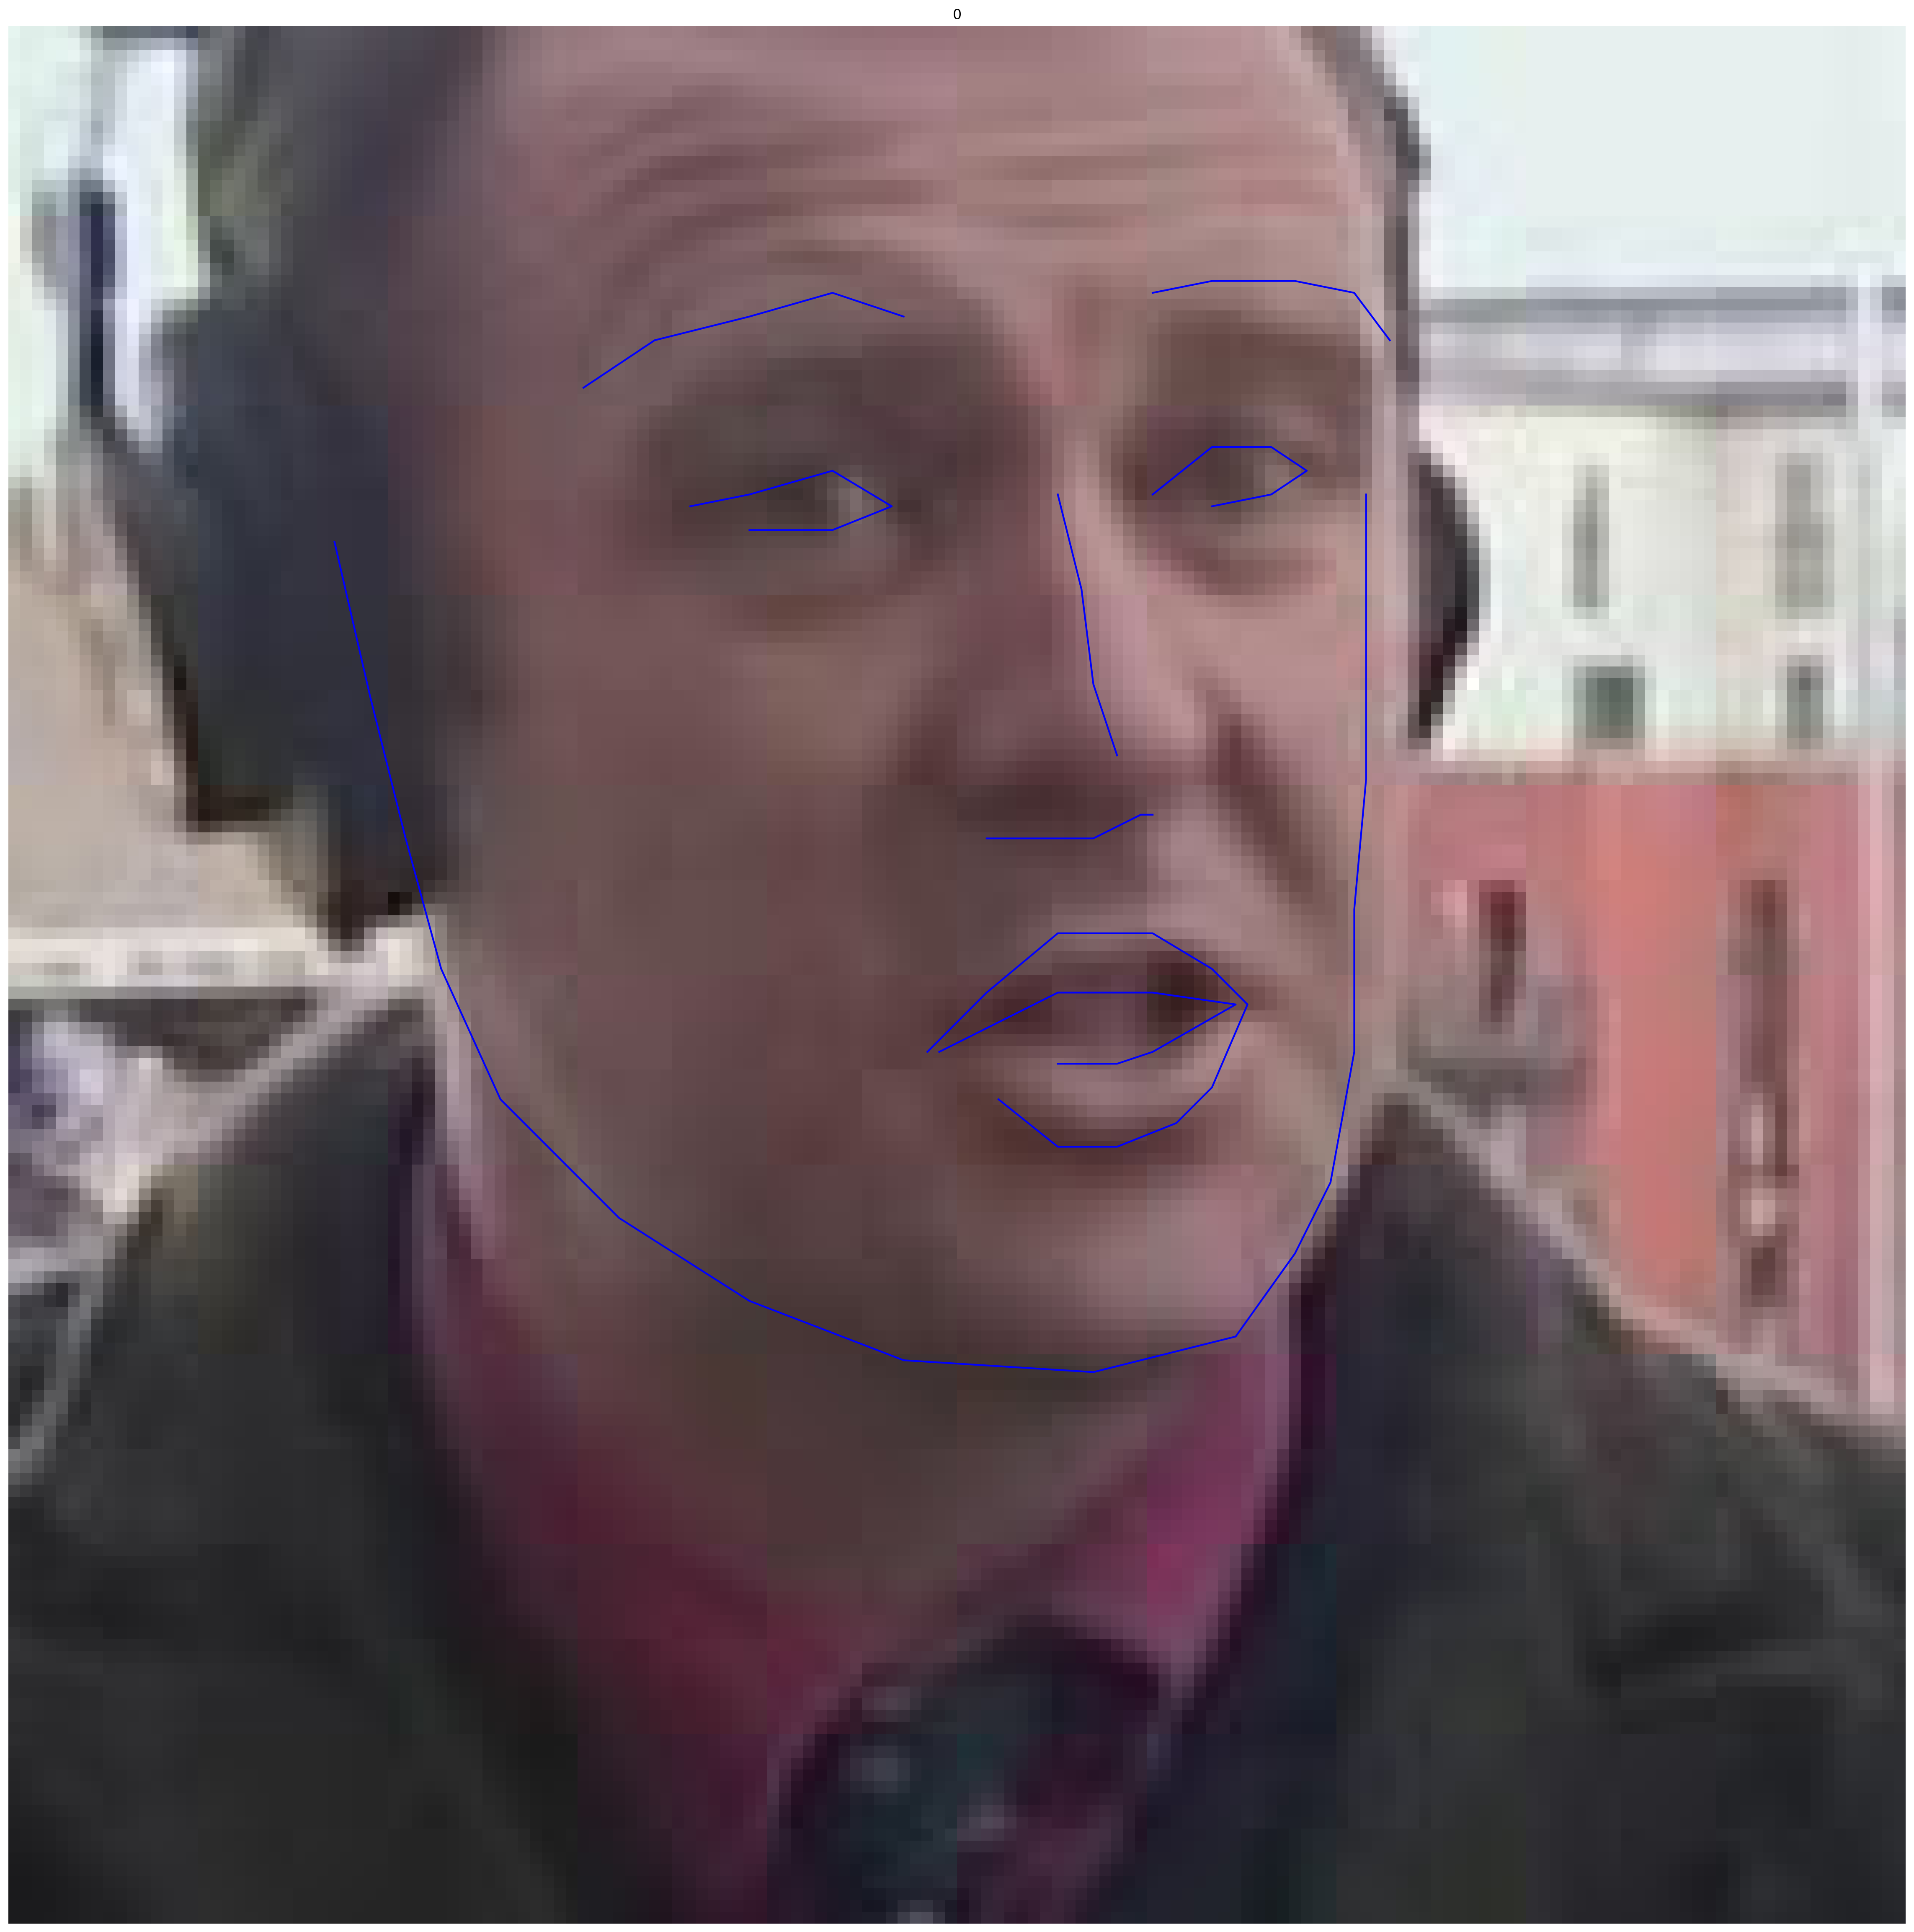

In [11]:
A2ED.plot_face(13100,"real")

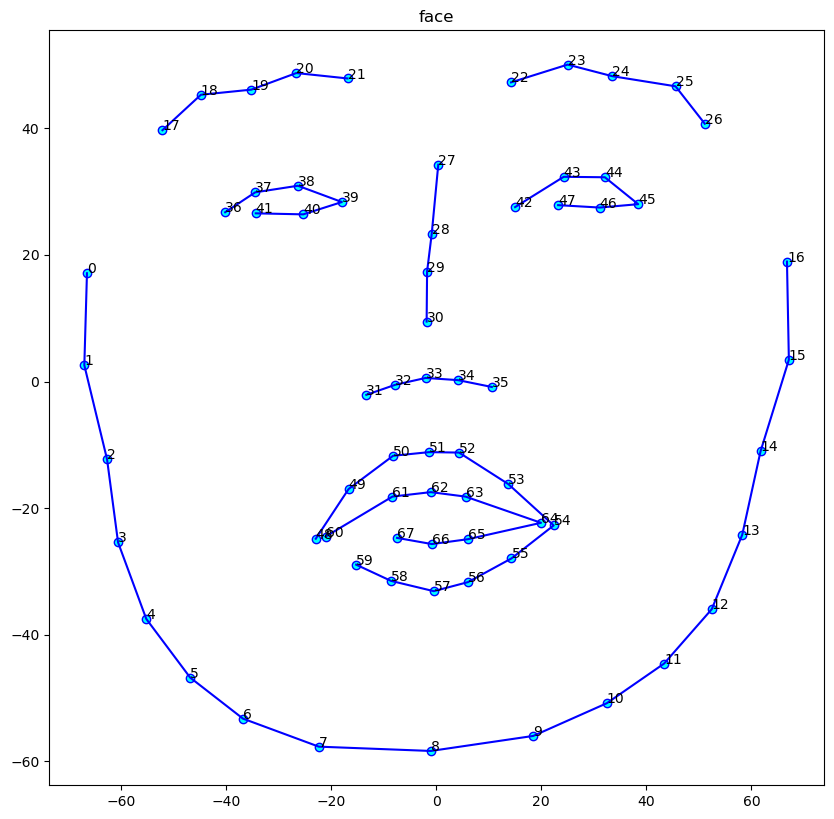

In [12]:
A2ED.plot_face(13100,"basel")

In [13]:
A2ED_train = AudioToExpressionDataset(df=df,subset_df = shuffle(df[df['datasplit']=="train"])[:10000].reset_index(),)


init dataset


In [14]:
A2ED_train.__getitem__(300)

{'cur': {'expression': tensor([[-1.0513e+00, -9.6985e-01, -2.3493e+00, -2.5433e+00, -1.2597e+00,
           -3.9756e-01, -1.3146e+00,  1.8970e+00,  9.7366e-01, -1.1669e+00,
            1.6344e+00, -1.5601e+00, -1.3301e+00,  9.9374e-01,  4.8746e-01,
           -1.1666e+00, -1.1388e+00,  4.6700e-01,  1.0480e+00,  7.5156e-01,
            8.1595e-01,  6.1640e-01,  2.1210e-01, -2.9773e+00, -2.1088e+00,
            1.7832e+00, -4.1704e-01,  8.2051e-01, -6.2601e-01,  1.3274e+00,
            1.0390e+00, -1.9808e+00, -1.4028e+00,  1.1081e-01, -4.1530e+00,
            1.0726e+00,  2.0119e+00,  2.3756e-01,  2.8152e+00, -2.7325e+00,
            2.0118e+00, -2.7524e+00, -9.2985e-01,  2.4200e+00, -4.2634e+00,
           -2.4633e+00,  2.2358e-01, -1.1710e+00, -1.7108e+00,  9.8831e-01,
            2.3088e+00,  1.9814e+00,  2.2174e+00,  2.3087e+00,  2.0434e+00,
           -1.8450e+00, -6.5433e-02, -1.8156e-01, -1.8235e+00, -9.8998e-01,
            3.8941e-02, -2.2488e+00, -2.8496e+00, -4.7472e+00, -3.3

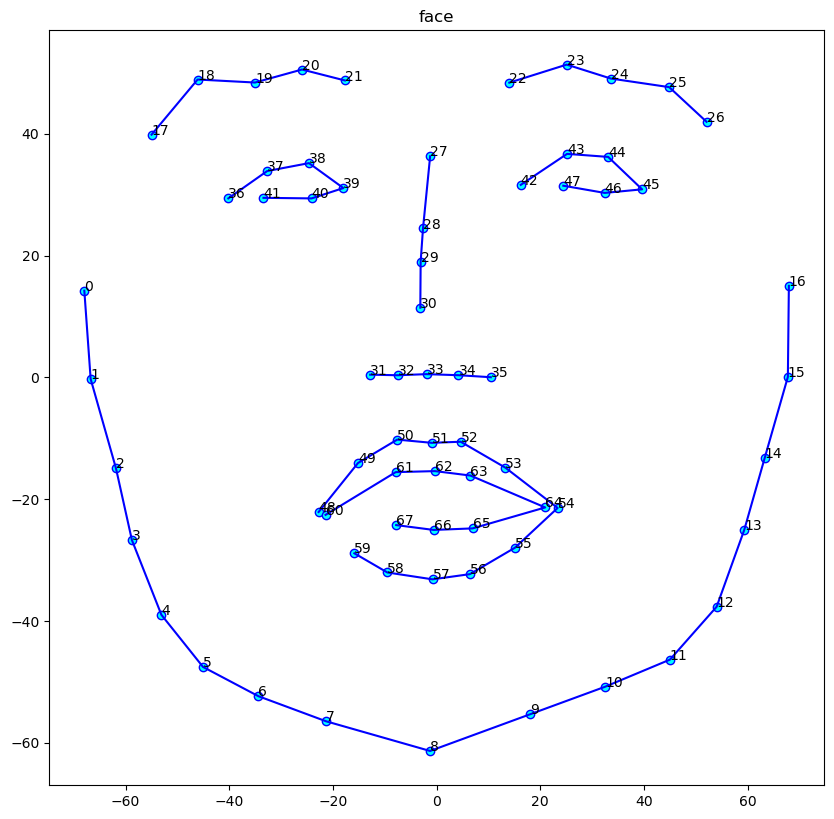

In [15]:
A2ED_train.plot_face(400,"basel")

In [16]:
loaded_expressions,_ = A2ED_train.load_video_expressions(100)

In [17]:
def match_expression(source_expression,stacked_expression,device,multipliers=(1,10),metric="L2",displacement = 1,print_loss=False):
    if type(source_expression)==list: 
        source_expression = torch.stack(source_expression)
    if type(stacked_expression)==list: 
        stacked_expression = torch.stack(stacked_expression)
        
    if "cpu" in device: 
        source_dlib = basel_cpu.get_expression(source_expression,2)
        stacked_dlib = basel_cpu.get_expression(stacked_expression,2)
    else:
        source_dlib = basel.get_expression(source_expression,2)
        stacked_dlib = basel.get_expression(stacked_expression,2)
    
    if len(source_dlib.shape)==2:
        source_dlib = source_dlib[None,None,:,:] 
    elif len(source_dlib.shape)==3:
        source_dlib = source_dlib[:,None,:,:] 
    
    stacked_dlib = stacked_dlib[None,:,:,:]
    
    
    
    mouth_idxs_norm = list(range(48, 68))
    mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:]
    mouth_source = source_dlib[:,:,mouth_idxs_norm,:]
    
    
    if displacement>0:
        idxs = list(range(68))
        idxs.append(idxs.pop(0))

        mouth_idxs_shifted = list(mouth_idxs_norm)
        for disp in range(displacement):
            mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))

        mouth_stacked = stacked_dlib[:,:,mouth_idxs_norm,:] - stacked_dlib[:,:,mouth_idxs_shifted,:]
        mouth_source = source_dlib[:,:,mouth_idxs_norm,:] - source_dlib[:,:,mouth_idxs_shifted,:]

        stacked_dlib = stacked_dlib - stacked_dlib[:,:,idxs,:]
        source_dlib = source_dlib - source_dlib[:,:,idxs,:]
            
    
    if metric.upper()=="L1":
        face_loss = multipliers[0]*torch.abs(stacked_dlib - source_dlib).sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).sum(dim=[2,3])
        z = face_loss + mouth_loss
    if metric.upper()=="L2":
        face_loss = multipliers[0]*torch.abs(stacked_dlib  - source_dlib).square().sum(dim=[2,3])
        mouth_loss =  multipliers[1]* (mouth_stacked - mouth_source).square().sum(dim=[2,3])
        z = face_loss + mouth_loss
    
    if print_loss: print(f"face: {face_loss.max()} mouth_loss {mouth_loss.max()}")
    sorted, indices = torch.sort(z,dim=1)
    return indices[0].tolist()

match_expression(loaded_expressions[1],loaded_expressions,"cpu",print_loss=True,displacement=1,multipliers=(1,10)).index(1)
    

face: 497.72125244140625 mouth_loss 1891.294677734375


0

In [18]:
# train_size = 0.8
# df = A2ED.df
# df['datasplit'] = 'test'

# g = df.groupby("directory")

# a=np.arange(g.ngroups)
# np.random.shuffle(a)

# cutoff = int(g.ngroups*train_size)
# df.loc[g.ngroup().isin(a[:cutoff]),'datasplit']='train'
# df.to_csv('workspace/data.csv')

# print(len(df[df['datasplit']=="train"])/len(df))
# len(df[df['datasplit']=="train"])

In [19]:
import torch.nn as nn
import torch

class LipGenerator(nn.Module):
    def __init__(self,T=3):
        super().__init__()
        self.T=T
        #################################
        #########   lip net   ###########
        #################################

        self.convNet = nn.Sequential(
            nn.Conv2d(29, 64, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), #  29 x 16 x 1 => 32 x 8 x 1
            nn.LeakyReLU(0.02, True),
            nn.Conv2d(64, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 8 x 1 => 32 x 4 x 1
            nn.LeakyReLU(0.02, True),
            nn.Conv2d(128, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 32 x 4 x 1 => 64 x 2 x 1
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 128, kernel_size=(3,1), stride=(2,1), padding=(1,0), bias=True), # 64 x 2 x 1 => 128 x 1 x 1
            nn.LeakyReLU(0.2, True),
        )
        


        self.linearNet = nn.Sequential(
            nn.Linear(in_features = 327 , out_features=400, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 400, out_features=400, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 400, out_features=300, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 300, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=199, bias = True),
            nn.LeakyReLU(0.02),
            nn.Linear(in_features = 199, out_features=100, bias = True),
        )
        
        self.attentionConvNet = nn.Sequential( # b x subspace_dim x seq_len
            nn.Conv1d(100, 16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(4, 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True),
            nn.Conv1d(2, 1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.02, True)
        )
        self.attentionNet = nn.Sequential(
            nn.Linear(in_features = self.T, out_features=self.T, bias = True),   
            nn.Softmax(dim=1)
        )
        

    def forward(self,deepspeech,shape):
        b = deepspeech.shape[0] # batchsize
        deepspeech = deepspeech.view(b * self.T, 1 , 16, 29) # b * seq_len x 1 x 16 x 29
        shape = shape.view(b * self.T, 1 , 199)
        
        deepspeech = torch.transpose(deepspeech,1,3) #b* seq_len  x 29 x 16 x 1
        conved = self.convNet(deepspeech) # b * seq_len X 128 X 1 X 1
        
        conved = torch.reshape( conved, (b * self.T, 1, -1)) # b * seq_len X 1 X 128
        
        catted = torch.cat([conved,shape],dim=-1)
        linear = self.linearNet(catted)[:,0,:]

        #################
        ### attention ###
        ################# 
        
        result_subspace = linear.view(b, self.T, 100) 
        result_subspace_T = torch.transpose(result_subspace, 1, 2) # b x subspace_dim x seq_len
        
        intermediate_expression = result_subspace_T[:,:,(self.T // 2):(self.T // 2) + 1] 
        
        
        att_conv_res = self.attentionConvNet(result_subspace_T) 
        
        attention = self.attentionNet(att_conv_res.view(b, self.T)).view(b, self.T, 1) # b x seq_len x 1
        
        result_subspace = torch.bmm(result_subspace_T, attention)
        return result_subspace.squeeze(),intermediate_expression.squeeze()


lip = LipGenerator()
for n in torch.utils.data.DataLoader(A2ED,batch_size=10,shuffle=True):
    lip(n['cur']['audio'],n['cur']['shape'])
    break
            

In [20]:
class MultiEpochsDataLoader(torch.utils.data.DataLoader):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._DataLoader__initialized = False
        self.batch_sampler = _RepeatSampler(self.batch_sampler)
        self._DataLoader__initialized = True
        self.iterator = super().__iter__()

    def __len__(self):
        return len(self.batch_sampler.sampler)

    def __iter__(self):
        for i in range(len(self)):
            yield next(self.iterator)
    
    def __del__(self):
        del self.iterator

class _RepeatSampler(object):
    """ Sampler that repeats forever.
    Args:
        sampler (Sampler)
    """

    def __init__(self, sampler):
        self.sampler = sampler

    def __iter__(self):
        while True:
            yield from iter(self.sampler)

# df=pd.read_csv('workspace/data.csv')
def get_loaders(args):
    
    
    A2ED_train = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="train"])[:args.data_size].reset_index(),T=args.seq_length)
    A2ED_test = AudioToExpressionDataset(df=df,subset_df=shuffle(df[df['datasplit']=="test"])[:args.data_size].reset_index(),T=args.seq_length)
    
    dataloader_params = {
         "batch_size":args.batch_size,
        "shuffle":args.shuffle, 
        "num_workers":args.num_workers,
#         "collate_fn":fn_collate,
    }
    if args.num_workers>0:
        dataloader_params["prefetch_factor"]=args.prefetch

    trainloader = MultiEpochsDataLoader(A2ED_train,**dataloader_params)

    testloader = torch.utils.data.DataLoader(A2ED_test,**dataloader_params)
    
    return {"test":testloader,
           "train":trainloader}

In [21]:
import torch.optim as optim

def lr_decay(step, init_learning_rate = 1e-3, min_learning_rate = 1e-5, decay_rate = 0.9999):
    lr = ((init_learning_rate - min_learning_rate) *
          pow(decay_rate, step) +
          min_learning_rate)
    return lr

def build_model(args):
    model = LipGenerator(T=args.seq_length).to(device)
    
    if args.optimizer=="adam":
        optimizer = optim.Adam(model.parameters(), lr=args.init_learning_rate)
    if args.optimizer=="ranger":
        optimizer = Ranger(model.parameters(), lr=args.init_learning_rate)
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: lr_decay(step,args.init_learning_rate,args.min_learning_rate,args.decay_rate)/args.init_learning_rate)
    if not args.pretrained == "":
        model.load_state_dict(torch.load(args.pretrained))

    return model,optimizer,scheduler

for x in range(10):
    print(lr_decay(x,0.1,0.0001,0.9))


0.1
0.09001
0.08101900000000001
0.07292710000000001
0.06564439000000001
0.05908995100000001
0.05319095590000001
0.04788186031000001
0.04310367427900001
0.03880330685110001


In [22]:
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [23]:
def train_and_test(model,optimizer,scheduler,loaders,args):
    running_loss = 0
    best_loss = -1
    step = 0
    torch.autograd.set_detect_anomaly(args.detect_anomaly)
    
    for epoch in tqdm(range(args.epochs)):  # loop over the dataset multiple times

        
        for split in ['train','test']:
            running_loss = 0
           
            if split == "train":
                model.train()
                loader = loaders['train']
                max_steps = args.trainsteps_per_epoch
            else:
                model.eval()
                loader=loaders['test']
                max_steps = args.test_steps_per_epoch
            running_loss = 0
            running_mouth_loss =0
            for i, data in enumerate(tqdm(loader)):
                # get the inputs; data is a list of [inputs, labels]
#                 audio, ground_expression_vector, ground_shape_vector,idxes = [d.to(device) for d in data]
                if i > max_steps:break
                step+=args.batch_size

                data = move_to(data,device)
            
                # forward + backward + optimize
                if split == "train":
                    audio_cat = torch.cat([data['prev']['audio'],data['cur']['audio'],data['nxt']['audio']])
                    shape_cat = torch.cat([data['prev']['shape'],data['cur']['shape'],data['nxt']['shape']])

                    output_expression_cat,intermediate_expression = model(audio_cat,shape_cat)

                    size = data['prev']['audio'].shape[0]
                    prev_output_expression = output_expression_cat[:size]
                    cur_output_expression = output_expression_cat[size:size*2]
                    nxt_output_expression = output_expression_cat[size*2:]
                    
                else:
                    with torch.no_grad():
                        
                        audio_cat = torch.cat([data['prev']['audio'],data['cur']['audio'],data['nxt']['audio']])
                        shape_cat = torch.cat([data['prev']['shape'],data['cur']['shape'],data['nxt']['shape']])

                        output_expression_cat,intermediate_expression = model(audio_cat,shape_cat)
                        
                        size = data['prev']['audio'].shape[0]
                        prev_output_expression = output_expression_cat[:size]
                        cur_output_expression = output_expression_cat[size:size*2]
                        nxt_output_expression = output_expression_cat[size*2:]

#                 if torch.isnan(audio_cat_gpu).any():
#                     print(f"contains nan: {output_expression_vector}")
#                     print(f"nan target: {ground_expression_vector} contains: {torch.isnan(ground_expression_vector).any()}max {ground_expression_vector.max()} min{ground_expression_vector.min()} ")
#                     print(f"nan input: {audio} contains: {torch.isnan(audio).any()} max {audio.max()} min{audio.min()}")

#                     print(f"prev target: {prev_ground_expression_vector} contains: {torch.isnan(prev_ground_expression_vector).any()}max {prev_ground_expression_vector.max()} min{prev_ground_expression_vector.min()} ")
#                     print(f"prev input: {prev_audio} contains: {torch.isnan(prev_audio).any()} max {prev_audio.max()} min{prev_audio.min()}")
#                     print(f"log_dict:{log_dict}")

#                     for n,p in model.named_parameters():
#                             print('===========\ngradient:{}\n----------\n{}'.format(n,p.grad))
#                             print('{} {}'.format(n,p.grad.max(),p.grad.min()))
#                             print('{} {}'.format(p.data.max(),p.data.min()))

#                     return

                # zero the parameter gradients
                optimizer.zero_grad()

                gt_expression_cur = data['cur']['expression'][:,args.seq_length//2,:]
                gt_expression_prev = data['prev']['expression'][:,args.seq_length//2,:]
                gt_expression_nxt = data['nxt']['expression'][:,args.seq_length//2,:]
            
            
                gt_expression_cat = torch.cat([gt_expression_prev,gt_expression_cur,gt_expression_nxt]).to(device)

                flat_intermediate_diff =  intermediate_expression - torch.cat([ data['prev']['expression'][:,args.seq_length//2,:], data['cur']['expression'][:,args.seq_length//2,:], data['nxt']['expression'][:,args.seq_length//2,:]])
                face_intermediate_diff = basel.get_expression(flat_intermediate_diff,2,add_means=False)
                
                #flat diff
                flat_diff = output_expression_cat - gt_expression_cat
                
                #face_diff
                face_diff = basel.get_expression(flat_diff,2,add_means=False)

                #temporal diffs
                temporal_prev_cur = (prev_output_expression - cur_output_expression) - (gt_expression_prev - gt_expression_cur)
                temporal_cur_next = (cur_output_expression - nxt_output_expression)  - (gt_expression_cur  - gt_expression_nxt)
                temporal_prev_next = (prev_output_expression - nxt_output_expression)- (gt_expression_prev - gt_expression_nxt)
                
                temporal_flat_cat = torch.cat([temporal_prev_cur,temporal_cur_next,temporal_prev_next])
                
                temporal_expression = basel.get_expression(temporal_flat_cat,2,add_means=False)
                
                
                
#                 if args.displacement>0:
#                     output_dlib = basel.get_expression(output_expression_vector,2,add_means=False)
#                     gt_dlib = basel.get_expression(ground_expression_vector,2,add_means=False)
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
                    
#                     if len(output_dlib.shape)==2:
#                         output_dlib = output_dlib[None,:,:]
#                         gt_dlib = gt_dlib[None,:,:]

                    
#                     idxs = list(range(68))
#                     idxs.append(idxs.pop(0))
                    
#                     mouth_idxs_norm = list(range(48, 68))
#                     mouth_idxs_shifted = list(mouth_idxs_norm)
#                     for disp in range(args.displacement):
#                         mouth_idxs_shifted.append(mouth_idxs_shifted.pop(0))
                    
#                     face_diff = (output_dlib - output_dlib[:,idxs,:]) - (gt_dlib - gt_dlib[:,idxs,:])
#                     mouth_diff = (output_dlib[:,mouth_idxs_norm,:] - output_dlib[:,mouth_idxs_shifted,:]) -( gt_dlib[:,mouth_idxs_norm,:] - gt_dlib[:,mouth_idxs_shifted,:])

                   
#                 else:
#                     face_diff = basel.get_expression(diff_vector,2,add_means=False)
#                     if len(output_diff.shape)==2:
#                         face_diff = face_diff[None,:,:]
#                     mouth_diff = face_diff[:,48:68,:]
                    

                #300 is batch size
                loss_dict = {}
                if args.metric=="L1": 
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.abs().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].abs().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.abs().mean()
                    
                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.abs().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.abs().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.abs().mean()
                    

                if args.metric == "L2":
                    loss_dict['face_loss']  = args.full_multiplier  * face_diff.square().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * face_diff[:,48:68,:].square().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * flat_diff.square().mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * face_intermediate_diff.square().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * temporal_flat_cat.square().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * temporal_expression.square().mean()
             

                if args.metric == "RMS":
                    eps = 1e-8
                    loss_dict['face_loss']  = args.full_multiplier  * (face_diff.square()+eps).sqrt().mean()
                    loss_dict['mouth_loss'] = args.mouth_multiplier * (face_diff[:,48:68,:].square()+eps).sqrt().mean()
                    loss_dict['flat_loss']  = args.flat_multiplier  * (flat_diff.square().sqrt()+eps).mean()
                    

                    loss_dict['intermediate'] = args.intermediate_multiplier * (face_intermediate_diff.square()+eps).sqrt().mean()
                    loss_dict['temporal_flat'] = args.temporal_flat_multiplier * (temporal_flat_cat.square()+eps).sqrt().mean()
                    loss_dict['temporal_face'] = args.temporal_face_multiplier * (temporal_expression.square()+eps).sqrt().mean()
                 
                
                loss = loss_dict['loss'] = sum(loss_dict.values())
                
                log_dict = {k:v.detach() for k,v in loss_dict.items()}
                log_dict['epoch'] = epoch
                
                
                if split=="train":
                    if i%args.retrieval_train_step==0 and epoch>=args.warmup_epochs:
                        retrieval = []
                        targets = []
                        predicted = []
                        with torch.no_grad():
                            #we use the 1th idx of cur, because this resembles the target idx
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:30],data['cur']['idx'][args.seq_length//2][:30])):
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                predicted.append(pred_sort[0])
                                retrieval.append((pred_sort.index(frame_idx))/len(video_gt))
                            print(f"train predicted: {predicted} \ntarget: {targets}")
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)

                    loss.backward()
                    if not args.clip is None:
                        torch.nn.utils.clip_grad_value_(model.parameters(), args.clip)

#                         if i%args.check_gradients==0:
#                             for n,p in model.named_parameters():
#                                 print('===========\ngradient:{}\n----------\n{} {} '.format(n,p.grad.max(),p.grad.min()))
#                                 print('===========\weigth:----------\n')
#                                 print('{} {}'.format(p.data.max(),p.data.min()))
#                             print('\n\n\n')


                    optimizer.step()
                    if args.use_wandb:
                        wandb.log(log_dict,step=step)
                else:
                    if i%args.retrieval_test_step==0 and epoch>=args.warmup_epochs:
                        with torch.no_grad():
                            retrieval = []
                            targets = []
                            predicted = []
                            for out_vector,target_idx in tqdm(zip(cur_output_expression[:50],data['cur']['idx'][args.seq_length//2][:50])):
                                
                                video_gt,frame_idx = loader.dataset.load_video_expressions(int(target_idx))
                                targets.append(frame_idx)
                                pred_sort = match_expression(out_vector.to("cpu"),torch.stack(video_gt),"cpu",multipliers=(1,10))
                                retrieval.append(pred_sort.index(frame_idx)/len(video_gt))
                                predicted.append(pred_sort[0])
                            print(f"test predicted: {predicted} \ntargets: {targets}")
                            
                            log_dict["retrieval"]=sum(retrieval)/len(retrieval)
                            log_dict["retrieval_std"] = np.std(retrieval)

                    if args.use_wandb:
                        wandb.log({"test_"+k:v for k,v in log_dict.items()},step=step)
            
            
            if split=="test":
                print(f"outputs max  {cur_output_expression.max(dim=1)[0][:5]} min {cur_output_expression.min(dim=1)[0][:5]}  mean {cur_output_expression.mean(dim=1)[:5]}")
                print(f"ground max  {gt_expression_cur.max(dim=1)[0][:5]} min {gt_expression_cur.min(dim=1)[0][:5]} mean {gt_expression_cur.mean(dim=1)[:5]}")

                print(f"eval [{epoch} {args.epochs}]: loss: {running_loss/(len(loader)*300)} mouth {running_mouth_loss/(len(loader)*300)}")
                if epoch>args.save_after: torch.save(model.state_dict(), 'checkpoints/training/{}{}.pt'.format(epoch, args.name))

                if best_loss==-1 or best_loss > running_loss:
                    best_loss = running_loss
                    if epoch>args.save_after:torch.save(model.state_dict(), 'checkpoints/training/best_{}.pt'.format(args.name))
                    print("new best")
            
            del loss_dict
            
        scheduler.step()
        print(f"new learning rate: {optimizer.param_groups[0]['lr']}")
    print('Finished Training')

In [24]:
def run(args):
    model,optimizer,scheduler = build_model(args)
    loaders = get_loaders(args)
    if args.use_wandb:
        wandb.init(project="lipgeneration",config=args,name=args.name)
        wandb.watch(model,log_freq=10)

    train_and_test(model,optimizer,scheduler,loaders,args)

In [29]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()

args.num_workers = 0
args.prefetch = 2
args.shuffle =True

args.batch_size = 800
args.full_multiplier = 2
args.mouth_multiplier = 8
args.flat_multiplier = 1
args.temporal_flat_multiplier = 1
args.temporal_face_multiplier = 3
args.intermediate_multiplier = 1




args.retrieval_train_step = 500
args.retrieval_test_step  = 1

args.trainsteps_per_epoch = 0
args.test_steps_per_epoch = 10000

args.clip = 1
args.detect_anomaly = False

args.check_gradients = 1000
args.metric = "L2"
args.epochs=1000
args.data_size = -1
args.print_step = 1000
args.displacement = 1
args.warmup_epochs = 0
args.save_after = 10000
args.seq_length = 3

args.init_learning_rate = 1e-3
args.min_learning_rate = 4e-5
args.decay_rate = 0.99
args.optimizer = "adam"

args.pretrained = "checkpoints/training/9L2-0.0005-1-shape->-1.pt" #"checkpoints/training/10L2-0.0004->-1.pt"
args.extra_name = "testrun"
args.use_wandb = True
args.name = f"{args.metric}-{args.init_learning_rate}-{args.displacement}{args.extra_name}->{args.data_size}"






In [30]:
run(args)

init dataset
init dataset


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2611 [00:00<?, ?it/s]

0it [00:00, ?it/s]

train predicted: [38, 35, 57, 49, 29, 26, 110, 85, 69, 36, 57, 39, 23, 14, 6, 63, 23, 9, 30, 24, 26, 6, 16, 21, 23, 25, 27, 17, 49, 99] 
target: [26, 39, 46, 2, 38, 23, 108, 38, 69, 76, 6, 35, 22, 98, 4, 72, 20, 8, 15, 41, 3, 5, 26, 0, 10, 44, 1, 16, 41, 96]


  0%|          | 0/654 [00:00<?, ?it/s]

0it [00:00, ?it/s]

test predicted: [72, 14, 19, 21, 10, 10, 100, 89, 79, 1, 119, 12, 30, 13, 12, 62, 45, 34, 41, 20, 9, 22, 81, 7, 117, 2, 15, 40, 44, 29, 25, 72, 61, 5, 29, 34, 5, 5, 10, 8, 29, 17, 132, 17, 20, 30, 1, 20, 40, 18] 
targets: [28, 60, 19, 47, 61, 14, 136, 98, 75, 29, 120, 10, 21, 30, 48, 95, 78, 20, 27, 19, 15, 3, 79, 39, 47, 64, 19, 17, 17, 46, 1, 85, 62, 5, 27, 26, 23, 0, 10, 12, 30, 63, 90, 16, 19, 44, 50, 17, 39, 20]


0it [00:00, ?it/s]

test predicted: [37, 13, 15, 31, 21, 29, 42, 18, 44, 23, 0, 34, 15, 19, 21, 24, 13, 47, 68, 11, 2, 80, 8, 3, 41, 6, 116, 88, 13, 35, 3, 41, 88, 65, 11, 33, 0, 19, 1, 6, 13, 100, 115, 37, 14, 61, 16, 17, 23, 41] 
targets: [47, 24, 16, 27, 1, 42, 24, 12, 42, 60, 5, 38, 38, 9, 10, 34, 19, 56, 60, 5, 46, 111, 72, 51, 19, 25, 18, 97, 29, 20, 0, 19, 12, 27, 29, 6, 53, 37, 12, 25, 11, 98, 85, 12, 18, 27, 34, 52, 30, 3]


0it [00:00, ?it/s]

test predicted: [32, 72, 34, 46, 5, 28, 13, 12, 38, 53, 25, 60, 33, 10, 48, 80, 0, 54, 21, 41, 14, 15, 4, 12, 15, 89, 21, 17, 19, 10, 19, 10, 45, 20, 4, 65, 9, 63, 127, 28, 6, 16, 44, 8, 3, 7, 79, 69, 15, 4] 
targets: [10, 54, 2, 41, 36, 26, 31, 23, 16, 53, 18, 36, 31, 34, 45, 60, 14, 19, 29, 4, 25, 43, 28, 40, 32, 13, 11, 18, 24, 38, 11, 45, 45, 15, 21, 20, 3, 16, 35, 28, 7, 5, 46, 26, 14, 16, 54, 27, 0, 30]


0it [00:00, ?it/s]

test predicted: [9, 30, 36, 31, 102, 30, 17, 40, 19, 33, 1, 12, 76, 3, 83, 57, 29, 92, 68, 105, 50, 42, 2, 14, 11, 52, 53, 23, 81, 33, 8, 2, 116, 40, 0, 25, 44, 13, 53, 32, 15, 17, 18, 24, 21, 34, 40, 19, 69, 64] 
targets: [8, 29, 60, 50, 146, 40, 11, 5, 42, 105, 60, 41, 39, 25, 95, 66, 62, 121, 97, 4, 51, 45, 15, 14, 14, 47, 46, 26, 11, 26, 82, 19, 111, 106, 68, 1, 5, 14, 26, 1, 84, 34, 5, 38, 30, 28, 48, 14, 74, 47]


0it [00:00, ?it/s]

test predicted: [1, 14, 51, 95, 19, 32, 32, 36, 14, 4, 77, 71, 1, 13, 8, 18, 54, 44, 31, 7, 36, 39, 37, 10, 19, 42, 14, 12, 45, 14, 1, 9, 1, 30, 41, 20, 0, 18, 71, 16, 58, 1, 15, 25, 29, 32, 53, 68, 45, 18] 
targets: [0, 103, 34, 85, 12, 32, 140, 23, 32, 1, 25, 76, 18, 1, 15, 17, 54, 40, 80, 22, 39, 5, 4, 20, 6, 3, 50, 14, 4, 12, 44, 54, 6, 37, 42, 49, 6, 28, 7, 18, 93, 2, 28, 5, 77, 5, 8, 29, 37, 62]


0it [00:00, ?it/s]

test predicted: [5, 40, 16, 20, 43, 9, 87, 33, 20, 101, 82, 32, 23, 8, 23, 30, 78, 64, 4, 26, 0, 44, 30, 8, 17, 56, 68, 136, 37, 73, 38, 45, 30, 55, 43, 95, 19, 32, 108, 39, 67, 18, 6, 61, 33, 59, 18, 73, 11, 16] 
targets: [30, 42, 82, 35, 3, 42, 7, 9, 8, 66, 53, 13, 22, 21, 21, 32, 37, 56, 26, 49, 2, 46, 59, 3, 0, 16, 14, 6, 63, 72, 43, 48, 39, 35, 29, 43, 105, 75, 72, 33, 51, 1, 27, 39, 31, 61, 13, 57, 48, 0]


0it [00:00, ?it/s]

test predicted: [40, 54, 59, 22, 44, 68, 11, 29, 10, 2, 52, 52, 49, 4, 48, 3, 22, 39, 1, 10, 50, 5, 1, 75, 8, 80, 29, 24, 20, 16, 74, 57, 31, 11, 79, 21, 40, 42, 58, 46, 133, 61, 91, 6, 28, 27, 9, 44, 29, 140] 
targets: [35, 39, 84, 22, 44, 63, 17, 27, 8, 9, 19, 88, 86, 2, 29, 43, 21, 14, 1, 14, 120, 33, 0, 12, 4, 3, 37, 14, 75, 3, 19, 36, 28, 14, 88, 4, 0, 47, 50, 58, 100, 35, 27, 0, 61, 61, 11, 29, 69, 121]


0it [00:00, ?it/s]

test predicted: [41, 95, 54, 48, 103, 30, 5, 30, 63, 11, 39, 19, 51, 21, 37, 38, 22, 21, 26, 12, 32, 1, 37, 15, 33, 3, 12, 4, 27, 42, 33, 26, 25, 51, 34, 51, 24, 59, 18, 70, 58, 64, 27, 74, 91, 101, 14, 34, 90, 2] 
targets: [54, 85, 10, 56, 8, 30, 30, 20, 48, 1, 41, 5, 52, 10, 36, 46, 22, 40, 4, 19, 22, 9, 8, 108, 29, 6, 9, 3, 4, 42, 19, 83, 21, 39, 23, 22, 21, 69, 28, 62, 1, 57, 71, 31, 60, 109, 18, 44, 4, 56]


0it [00:00, ?it/s]

test predicted: [12, 63, 13, 14, 0, 17, 32, 16, 38, 9, 7, 25, 1, 70, 14, 8, 2, 39, 13, 35, 11, 45, 25, 37, 27, 91, 35, 3, 97, 5, 0, 18, 49, 3, 29, 9, 105, 23, 27, 83, 19, 32, 4, 24, 1, 19, 15, 5, 17, 52] 
targets: [19, 22, 28, 39, 30, 35, 24, 13, 97, 7, 40, 28, 20, 19, 20, 21, 10, 43, 4, 23, 1, 65, 16, 31, 69, 37, 29, 8, 80, 44, 24, 15, 49, 3, 45, 2, 9, 35, 16, 74, 23, 15, 1, 36, 36, 15, 18, 1, 50, 33]


0it [00:00, ?it/s]

test predicted: [55, 59, 12, 3, 41, 11, 62, 6, 16, 7, 35, 39, 46, 27, 28, 22, 43, 88, 16, 61, 87, 0, 36, 102, 1, 6, 2, 2, 88, 38, 0, 7, 33, 37, 6, 27, 1, 20, 64, 56, 43, 33, 103, 24, 8, 15, 55, 127, 108, 29] 
targets: [62, 56, 32, 10, 98, 7, 1, 6, 57, 16, 18, 31, 54, 19, 11, 51, 9, 90, 19, 83, 33, 21, 116, 8, 33, 23, 19, 28, 87, 1, 30, 7, 11, 24, 16, 8, 10, 99, 19, 16, 36, 29, 87, 16, 55, 29, 38, 41, 30, 42]


0it [00:00, ?it/s]

test predicted: [28, 10, 20, 138, 40, 23, 89, 101, 42, 20, 28, 24, 30, 12, 4, 22, 27, 46, 104, 76, 31, 24, 36, 2, 15, 27, 8, 26, 30, 74, 34, 95, 65, 11, 16, 67, 25, 19, 20, 51, 23, 21, 22, 7, 26, 8, 45, 26, 65, 28] 
targets: [64, 32, 19, 67, 36, 10, 92, 43, 47, 22, 48, 1, 3, 14, 43, 28, 38, 19, 111, 16, 8, 20, 45, 59, 7, 11, 0, 24, 58, 2, 30, 97, 19, 37, 18, 9, 71, 29, 67, 30, 30, 17, 9, 10, 18, 8, 58, 5, 67, 87]


0it [00:00, ?it/s]

test predicted: [38, 18, 23, 134, 25, 53, 57, 106, 48, 17, 82, 83, 46, 9, 16, 23, 7, 14, 17, 38, 1, 22, 23, 38, 7, 25, 35, 94, 25, 22, 32, 31, 25, 75, 31, 31, 57, 19, 136, 40, 43, 16, 25, 42, 8, 28, 6, 22, 18, 30] 
targets: [33, 25, 37, 5, 24, 20, 26, 75, 24, 9, 95, 27, 11, 29, 25, 36, 1, 20, 24, 4, 73, 12, 6, 56, 104, 0, 44, 42, 29, 139, 1, 16, 32, 52, 73, 14, 58, 22, 86, 42, 85, 34, 37, 31, 6, 23, 27, 16, 20, 7]


0it [00:00, ?it/s]

test predicted: [38, 12, 2, 72, 20, 19, 26, 15, 52, 26, 62, 17, 10, 39, 111, 35, 28, 26, 12, 72, 62, 47, 83, 35, 49, 93, 19, 1, 14, 71, 19, 38, 78, 24, 29, 42, 9, 5, 32, 43, 63, 14, 6, 25, 12, 19, 28, 78, 50, 16] 
targets: [25, 22, 30, 136, 33, 33, 26, 30, 46, 35, 6, 17, 14, 19, 11, 40, 40, 29, 24, 45, 58, 55, 80, 1, 45, 95, 16, 30, 18, 2, 13, 38, 69, 58, 17, 5, 65, 22, 33, 61, 67, 22, 26, 26, 9, 17, 67, 67, 82, 16]


0it [00:00, ?it/s]

test predicted: [7, 19, 68, 7, 20, 73, 7, 65, 36, 62, 23, 110, 24, 13, 84, 27, 52, 74, 44, 53, 52, 0, 36, 24, 29, 3, 3, 6, 35, 11, 93, 51, 6, 33, 48, 15, 22, 9, 2, 9, 28, 83, 38, 24, 6, 57, 81, 87, 11, 68] 
targets: [22, 2, 52, 30, 78, 2, 113, 1, 61, 13, 7, 33, 18, 17, 75, 2, 100, 25, 10, 9, 52, 4, 24, 35, 24, 33, 4, 5, 15, 13, 61, 49, 28, 24, 16, 23, 51, 10, 0, 2, 4, 36, 41, 20, 0, 49, 8, 128, 13, 71]


0it [00:00, ?it/s]

test predicted: [38, 8, 22, 16, 28, 17, 57, 55, 23, 35, 107, 23, 60, 82, 8, 7, 34, 13, 16, 6, 24, 92, 76, 57, 45, 26, 22, 9, 30, 3, 29, 3, 33, 60, 15, 15, 26, 2, 31, 5, 0, 73, 39, 9, 31, 12, 20, 19, 6, 7] 
targets: [33, 14, 16, 79, 24, 39, 0, 9, 3, 18, 68, 21, 31, 31, 53, 5, 33, 32, 71, 19, 5, 55, 62, 79, 4, 29, 64, 38, 121, 3, 36, 23, 15, 10, 19, 36, 29, 18, 19, 52, 18, 48, 31, 52, 74, 30, 70, 2, 44, 10]


0it [00:00, ?it/s]

test predicted: [40, 58, 12, 2, 6, 27, 26, 69, 62, 19, 78, 22, 5, 7, 14, 9, 32, 11, 34, 129, 83, 23, 19, 5, 26, 13, 1, 7, 10, 21, 17, 40, 114, 3, 130, 54, 73, 62, 45, 22, 78, 8, 30, 8, 3, 65, 6, 43, 64, 25] 
targets: [8, 26, 16, 11, 1, 135, 26, 64, 11, 4, 92, 6, 17, 13, 23, 16, 24, 11, 9, 101, 72, 93, 5, 31, 58, 25, 2, 1, 12, 31, 16, 41, 74, 5, 87, 5, 98, 79, 45, 17, 111, 29, 11, 7, 56, 100, 39, 16, 5, 17]


0it [00:00, ?it/s]

test predicted: [55, 19, 41, 63, 27, 79, 26, 51, 0, 38, 3, 74, 51, 69, 36, 6, 25, 15, 6, 13, 97, 2, 12, 6, 65, 48, 41, 0, 46, 29, 6, 37, 35, 18, 27, 17, 66, 21, 44, 10, 59, 38, 54, 105, 8, 39, 58, 32, 24, 9] 
targets: [56, 14, 9, 23, 4, 50, 16, 22, 30, 29, 3, 99, 64, 50, 14, 14, 20, 7, 9, 8, 39, 1, 16, 9, 12, 49, 26, 2, 34, 23, 11, 3, 39, 7, 40, 27, 49, 12, 34, 22, 48, 21, 59, 118, 55, 21, 13, 36, 36, 10]


0it [00:00, ?it/s]

test predicted: [46, 41, 18, 2, 86, 37, 42, 62, 28, 29, 18, 11, 4, 1, 53, 43, 32, 27, 46, 6, 4, 47, 30, 13, 11, 31, 5, 57, 35, 0, 26, 24, 30, 69, 7, 14, 102, 20, 6, 18, 136, 8, 18, 10, 45, 9, 0, 37, 20, 35] 
targets: [14, 34, 3, 7, 62, 16, 52, 25, 3, 23, 44, 47, 35, 28, 80, 22, 6, 37, 41, 17, 17, 69, 18, 20, 15, 33, 24, 3, 10, 32, 8, 23, 19, 119, 4, 7, 88, 41, 2, 127, 123, 32, 4, 46, 102, 6, 2, 16, 36, 14]


0it [00:00, ?it/s]

test predicted: [26, 3, 18, 5, 42, 7, 88, 4, 35, 96, 39, 40, 6, 23, 63, 10, 30, 39, 24, 13, 12, 28, 19, 48, 49, 2, 48, 19, 40, 12, 70, 1, 13, 87, 9, 28, 73, 59, 39, 50, 7, 74, 20, 107, 14, 18, 13, 64, 25, 37] 
targets: [24, 127, 10, 4, 23, 23, 73, 31, 35, 58, 17, 4, 19, 43, 62, 1, 8, 4, 2, 12, 28, 67, 24, 12, 7, 11, 45, 18, 107, 16, 108, 36, 43, 26, 67, 34, 5, 23, 19, 33, 55, 71, 22, 82, 22, 31, 14, 101, 28, 39]


0it [00:00, ?it/s]

test predicted: [77, 3, 6, 49, 22, 7, 0, 43, 26, 13, 14, 27, 17, 127, 44, 35, 2, 16, 4, 36, 40, 29, 15, 4, 38, 8, 19, 29, 16, 30, 8, 72, 55, 36, 12, 5, 22, 32, 45, 24, 90, 37, 53, 31, 12, 23, 12, 42, 37, 7] 
targets: [33, 31, 71, 106, 37, 29, 26, 37, 30, 5, 15, 115, 21, 69, 50, 38, 25, 10, 55, 28, 22, 3, 44, 15, 39, 29, 51, 70, 14, 30, 4, 86, 103, 9, 24, 21, 56, 42, 117, 11, 92, 45, 28, 5, 27, 27, 2, 93, 13, 10]


0it [00:00, ?it/s]

test predicted: [83, 30, 22, 58, 35, 5, 12, 14, 67, 38, 17, 15, 54, 3, 78, 80, 19, 46, 37, 57, 66, 19, 65, 14, 3, 24, 105, 53, 20, 28, 14, 5, 91, 7, 55, 18, 3, 32, 121, 71, 43, 26, 27, 18, 32, 18, 58, 3, 38, 64] 
targets: [43, 32, 75, 69, 23, 4, 11, 10, 23, 71, 49, 55, 77, 20, 74, 72, 4, 44, 31, 10, 51, 14, 69, 25, 17, 13, 108, 54, 9, 32, 2, 40, 93, 14, 23, 16, 20, 57, 54, 50, 70, 21, 14, 8, 24, 20, 36, 36, 24, 53]


0it [00:00, ?it/s]

test predicted: [15, 24, 37, 14, 20, 3, 26, 65, 75, 32, 40, 135, 8, 124, 21, 40, 28, 39, 107, 71, 18, 0, 45, 7, 18, 11, 14, 28, 62, 48, 28, 9, 27, 9, 23, 17, 21, 4, 93, 25, 26, 51, 30, 16, 32, 60, 23, 7, 25, 59] 
targets: [16, 34, 18, 30, 21, 23, 13, 20, 2, 4, 125, 29, 20, 3, 3, 22, 35, 68, 57, 73, 61, 34, 35, 5, 13, 11, 29, 7, 29, 45, 29, 20, 7, 102, 40, 46, 22, 37, 62, 24, 12, 39, 38, 22, 16, 18, 28, 0, 0, 44]


0it [00:00, ?it/s]

test predicted: [42, 18, 42, 3, 28, 49, 16, 52, 10, 44, 0, 4, 101, 2, 1, 49, 30, 36, 31, 1, 26, 66, 48, 13, 61, 20, 32, 88, 35, 24, 55, 49, 22, 3, 8, 12, 25, 14, 25, 4, 18, 12, 6, 54, 22, 4, 22, 3, 37, 8] 
targets: [80, 27, 44, 15, 39, 46, 16, 12, 51, 70, 8, 40, 4, 35, 5, 6, 55, 83, 12, 101, 53, 15, 41, 26, 53, 12, 13, 66, 4, 48, 23, 24, 83, 0, 116, 10, 27, 23, 19, 43, 4, 0, 0, 31, 27, 3, 7, 2, 1, 7]


0it [00:00, ?it/s]

test predicted: [84, 81, 41, 35, 9, 49, 76, 21, 1, 19, 31, 9, 13, 18, 27, 2, 38, 2, 41, 19, 30, 17, 53, 22, 9, 24, 9, 21, 10, 13, 17, 47, 58, 43, 17, 87, 50, 49, 54, 24, 25, 52, 36, 51, 12, 40, 29, 23, 4, 84] 
targets: [133, 53, 53, 22, 17, 27, 36, 4, 0, 20, 3, 32, 3, 14, 20, 6, 12, 2, 4, 17, 77, 12, 17, 3, 75, 23, 25, 32, 11, 1, 14, 30, 146, 46, 23, 30, 77, 18, 60, 20, 29, 41, 37, 59, 5, 74, 23, 20, 45, 98]


0it [00:00, ?it/s]

test predicted: [47, 0, 63, 30, 33, 17, 20, 2, 17, 14, 44, 11, 51, 21, 30, 13, 0, 20, 7, 77, 23, 28, 35, 14, 21, 28, 5, 3, 56, 9, 10, 16, 37, 27, 1, 10, 5, 3, 66, 132, 129, 40, 55, 16, 94, 21, 9, 15, 62, 98] 
targets: [30, 32, 98, 68, 34, 33, 33, 12, 6, 52, 2, 31, 33, 27, 53, 29, 18, 5, 33, 64, 13, 19, 34, 12, 23, 72, 32, 38, 139, 10, 10, 63, 25, 36, 18, 34, 8, 39, 26, 6, 54, 43, 107, 11, 42, 26, 13, 23, 69, 98]


0it [00:00, ?it/s]

test predicted: [30, 0, 42, 72, 39, 67, 22, 26, 15, 71, 12, 44, 71, 14, 21, 55, 23, 17, 13, 124, 95, 20, 73, 20, 14, 54, 28, 22, 69, 28, 108, 35, 28, 15, 25, 45, 30, 30, 35, 20, 68, 13, 66, 24, 4, 16, 38, 56, 18, 80] 
targets: [36, 27, 34, 128, 65, 105, 24, 61, 15, 37, 12, 0, 12, 25, 95, 20, 13, 30, 69, 139, 93, 25, 93, 32, 6, 33, 13, 43, 47, 23, 96, 35, 25, 73, 32, 33, 41, 13, 6, 35, 61, 0, 2, 22, 3, 39, 20, 99, 3, 12]


0it [00:00, ?it/s]

test predicted: [27, 2, 21, 0, 21, 21, 123, 43, 33, 1, 100, 56, 45, 79, 83, 0, 37, 3, 30, 2, 19, 29, 59, 66, 67, 71, 14, 69, 13, 125, 37, 118, 20, 40, 10, 34, 17, 25, 13, 14, 45, 42, 13, 113, 59, 48, 63, 62, 45, 10] 
targets: [23, 8, 21, 45, 66, 3, 6, 1, 12, 16, 122, 26, 0, 50, 135, 5, 63, 20, 28, 29, 21, 47, 13, 41, 43, 12, 5, 77, 14, 66, 48, 39, 17, 70, 30, 77, 16, 4, 11, 30, 12, 0, 21, 19, 9, 37, 58, 64, 31, 9]


0it [00:00, ?it/s]

test predicted: [75, 59, 66, 20, 14, 49, 17, 26, 21, 39, 47, 125, 17, 2, 96, 91, 102, 29, 53, 9, 3, 37, 2, 56, 4, 9, 9, 78, 74, 14, 50, 0, 34, 2, 3, 63, 3, 37, 42, 27, 43, 30, 45, 0, 49, 32, 63, 79, 26, 8] 
targets: [5, 57, 14, 20, 18, 17, 18, 117, 19, 25, 48, 50, 6, 11, 103, 96, 109, 5, 46, 69, 13, 12, 9, 32, 25, 32, 5, 103, 28, 23, 59, 59, 25, 68, 4, 61, 31, 34, 50, 25, 28, 47, 115, 23, 50, 21, 47, 46, 6, 20]


0it [00:00, ?it/s]

test predicted: [57, 29, 30, 58, 28, 9, 15, 35, 32, 0, 86, 23, 56, 15, 34, 28, 67, 2, 37, 17, 40, 17, 15, 35, 34, 28, 2, 15, 41, 92, 62, 18, 24, 4, 101, 57, 3, 40, 11, 88, 38, 20, 47, 25, 16, 20, 30, 27, 13, 10] 
targets: [57, 47, 34, 77, 15, 17, 21, 89, 19, 32, 115, 87, 43, 12, 30, 96, 22, 12, 38, 12, 6, 21, 2, 8, 5, 29, 5, 12, 90, 51, 62, 27, 10, 18, 122, 21, 47, 20, 16, 81, 7, 23, 113, 115, 15, 73, 25, 27, 68, 30]


0it [00:00, ?it/s]

test predicted: [18, 23, 32, 16, 52, 26, 5, 18, 18, 49, 9, 59, 7, 18, 42, 32, 18, 35, 63, 36, 45, 30, 56, 9, 13, 14, 27, 57, 20, 72, 36, 148, 27, 9, 21, 81, 24, 53, 21, 66, 42, 6, 47, 55, 54, 24, 53, 5, 22, 13] 
targets: [31, 125, 15, 3, 7, 23, 8, 13, 10, 51, 7, 86, 6, 2, 35, 35, 14, 4, 62, 28, 45, 32, 121, 82, 12, 3, 16, 58, 9, 62, 25, 55, 29, 12, 22, 66, 24, 54, 47, 48, 2, 16, 24, 77, 47, 109, 6, 15, 23, 4]


0it [00:00, ?it/s]

test predicted: [1, 0, 49, 14, 48, 59, 40, 19, 13, 16, 106, 14, 64, 77, 18, 18, 13, 11, 39, 39, 20, 19, 36, 29, 19, 4, 32, 53, 1, 35, 11, 34, 99, 19, 9, 13, 32, 128, 33, 47, 61, 28, 47, 78, 20, 51, 67, 17, 15, 49] 
targets: [52, 36, 49, 40, 129, 58, 1, 17, 59, 4, 6, 23, 57, 2, 14, 7, 39, 25, 29, 43, 20, 43, 60, 27, 20, 5, 45, 71, 5, 26, 26, 14, 57, 73, 0, 44, 34, 102, 33, 0, 61, 7, 123, 42, 21, 11, 28, 31, 16, 79]


0it [00:00, ?it/s]

test predicted: [6, 39, 91, 9, 27, 63, 48, 64, 19, 24, 5, 5, 81, 65, 9, 19, 102, 15, 6, 51, 20, 10, 3, 32, 13, 22, 22, 67, 42, 17, 99, 20, 9, 20, 2, 10, 31, 12, 3, 12, 34, 31, 2, 64, 34, 4, 17, 3, 55, 32] 
targets: [14, 1, 51, 20, 70, 101, 125, 44, 12, 20, 11, 69, 21, 22, 25, 36, 15, 2, 3, 20, 19, 3, 4, 32, 12, 56, 94, 42, 139, 53, 61, 7, 8, 23, 26, 10, 19, 14, 3, 29, 36, 57, 18, 29, 52, 47, 25, 2, 64, 19]


0it [00:00, ?it/s]

test predicted: [59, 74, 7, 5, 6, 40, 18, 65, 61, 3, 16, 56, 48, 52, 19, 22, 27, 14, 134, 23, 16, 33, 26, 39, 27, 41, 37, 5, 1, 19, 50, 45, 26, 24, 19, 20, 11, 50, 22, 26, 0, 6, 40, 6, 29, 34, 77, 35, 8, 6] 
targets: [34, 48, 5, 37, 24, 17, 17, 59, 9, 26, 7, 59, 76, 46, 14, 3, 8, 27, 144, 2, 43, 28, 29, 63, 35, 28, 22, 31, 40, 3, 91, 32, 18, 23, 24, 35, 34, 23, 6, 14, 10, 32, 40, 114, 76, 30, 147, 5, 22, 5]


0it [00:00, ?it/s]

test predicted: [4, 12, 5, 2, 6, 35, 40, 46, 44, 79, 5, 29, 71, 35, 23, 76, 78, 11, 23, 76, 9, 9, 15, 51, 51, 9, 80, 13, 32, 99, 32, 47, 11, 61, 21, 28, 5, 9, 39, 62, 15, 56, 9, 7, 36, 34, 14, 41, 3, 18] 
targets: [2, 13, 25, 34, 46, 18, 62, 9, 15, 16, 0, 20, 56, 37, 32, 26, 16, 42, 11, 23, 29, 11, 8, 39, 37, 15, 80, 12, 35, 81, 17, 33, 6, 132, 18, 13, 16, 19, 26, 85, 19, 69, 81, 24, 37, 32, 12, 46, 49, 114]


0it [00:00, ?it/s]

test predicted: [18, 0, 1, 3, 60, 12, 14, 46, 19, 11, 47, 10, 3, 11, 49, 16, 17, 87, 0, 15, 23, 65, 29, 22, 115, 54, 12, 103, 21, 61, 2, 54, 8, 12, 28, 5, 11, 13, 21, 18, 83, 11, 62, 38, 54, 2, 12, 13, 13, 55] 
targets: [29, 25, 40, 6, 23, 39, 1, 42, 38, 26, 28, 35, 3, 0, 46, 49, 34, 2, 11, 15, 5, 141, 15, 15, 26, 5, 44, 115, 11, 45, 50, 40, 9, 14, 30, 44, 67, 0, 9, 7, 14, 21, 64, 29, 32, 1, 14, 13, 7, 32]


0it [00:00, ?it/s]

test predicted: [4, 8, 5, 15, 34, 73, 45, 5, 17, 33, 51, 22, 52, 26, 13, 11, 46, 6, 60, 22, 1, 59, 12, 34, 57, 14, 35, 35, 22, 32, 54, 11, 12, 74, 128, 3, 42, 59, 6, 24, 58, 87, 70, 23, 63, 29, 53, 21, 32, 55] 
targets: [8, 16, 20, 4, 46, 61, 4, 35, 10, 23, 36, 37, 28, 27, 19, 2, 12, 10, 35, 10, 10, 7, 12, 26, 42, 25, 34, 50, 51, 45, 36, 19, 1, 18, 16, 37, 78, 20, 46, 22, 40, 25, 94, 32, 102, 20, 75, 9, 14, 14]


0it [00:00, ?it/s]

test predicted: [72, 28, 0, 36, 78, 17, 7, 36, 42, 22, 92, 8, 45, 30, 14, 32, 59, 82, 14, 66, 30, 59, 0, 31, 0, 16, 44, 36, 18, 20, 19, 95, 25, 54, 14, 112, 53, 100, 64, 0, 36, 25, 4, 61, 119, 3, 14, 11, 8, 25] 
targets: [73, 52, 82, 16, 77, 2, 29, 20, 9, 9, 96, 3, 5, 34, 29, 4, 1, 77, 39, 111, 30, 36, 43, 49, 68, 6, 6, 47, 16, 3, 19, 52, 1, 24, 23, 11, 14, 86, 39, 10, 6, 9, 44, 72, 108, 17, 30, 33, 9, 30]


0it [00:00, ?it/s]

test predicted: [92, 6, 6, 9, 8, 31, 17, 16, 9, 26, 30, 25, 57, 18, 20, 0, 21, 5, 33, 11, 9, 46, 44, 78, 124, 22, 19, 22, 27, 70, 31, 86, 4, 106, 25, 2, 6, 17, 41, 66, 12, 5, 13, 60, 62, 50, 10, 23, 63, 28] 
targets: [0, 38, 28, 44, 36, 7, 17, 39, 51, 22, 37, 51, 42, 42, 20, 14, 7, 43, 15, 32, 114, 22, 122, 130, 9, 9, 6, 49, 5, 44, 9, 24, 58, 122, 29, 32, 4, 18, 57, 99, 19, 64, 22, 46, 90, 24, 34, 5, 22, 23]


0it [00:00, ?it/s]

test predicted: [51, 9, 42, 78, 28, 27, 39, 47, 19, 13, 22, 81, 35, 63, 13, 19, 24, 6, 5, 1, 7, 0, 48, 4, 5, 45, 32, 64, 6, 29, 7, 15, 59, 44, 31, 51, 46, 35, 2, 31, 0, 32, 66, 64, 48, 19, 32, 56, 3, 85] 
targets: [112, 17, 21, 6, 27, 37, 35, 6, 24, 42, 4, 110, 25, 51, 29, 52, 11, 14, 34, 18, 4, 14, 19, 44, 23, 9, 34, 67, 20, 29, 74, 1, 34, 36, 51, 55, 26, 38, 56, 5, 84, 36, 67, 10, 57, 74, 117, 54, 3, 59]


0it [00:00, ?it/s]

test predicted: [34, 32, 22, 94, 8, 72, 23, 25, 2, 9, 67, 51, 34, 145, 25, 33, 8, 145, 26, 41, 2, 5, 26, 17, 11, 34, 52, 7, 6, 36, 5, 3, 65, 1, 27, 5, 12, 33, 44, 1, 24, 62, 17, 22, 4, 9, 42, 0, 137, 10] 
targets: [30, 19, 20, 7, 24, 32, 32, 22, 5, 35, 91, 7, 139, 75, 4, 13, 16, 45, 20, 18, 38, 25, 47, 40, 15, 5, 25, 13, 28, 34, 14, 89, 82, 1, 51, 22, 14, 21, 81, 39, 27, 26, 32, 11, 7, 27, 2, 43, 50, 19]


0it [00:00, ?it/s]

test predicted: [126, 20, 14, 40, 55, 59, 13, 18, 32, 12, 16, 5, 15, 102, 72, 53, 38, 25, 72, 16, 6, 64, 6, 14, 6, 11, 10, 7, 68, 1, 31, 22, 1, 36, 38, 35, 15, 9, 43, 27, 10, 64, 36, 6, 43, 10, 73, 18, 34, 17] 
targets: [16, 122, 3, 54, 60, 19, 13, 26, 30, 14, 4, 9, 4, 83, 27, 13, 17, 53, 95, 44, 14, 51, 98, 20, 32, 27, 46, 11, 6, 36, 1, 21, 0, 41, 94, 45, 5, 56, 21, 9, 27, 67, 3, 17, 13, 21, 18, 69, 74, 9]


0it [00:00, ?it/s]

test predicted: [30, 11, 26, 65, 22, 48, 12, 77, 45, 17, 64, 9, 55, 20, 11, 69, 13, 2, 45, 73, 20, 29, 39, 44, 19, 40, 6, 5, 42, 13, 0, 4, 7, 136, 5, 50, 12, 1, 44, 6, 34, 56, 12, 14, 42, 15, 58, 15, 0, 6] 
targets: [3, 6, 2, 55, 51, 34, 38, 98, 36, 50, 4, 11, 29, 30, 7, 14, 38, 31, 4, 62, 2, 5, 68, 32, 0, 20, 16, 7, 83, 35, 8, 2, 100, 80, 31, 38, 29, 10, 53, 52, 58, 55, 34, 3, 25, 8, 48, 25, 12, 20]


0it [00:00, ?it/s]

test predicted: [40, 32, 38, 25, 67, 13, 23, 70, 60, 22, 15, 37, 121, 14, 45, 21, 61, 15, 106, 42, 22, 1, 0, 4, 103, 6, 57, 4, 13, 5, 42, 47, 26, 61, 25, 0, 49, 7, 5, 42, 71, 100, 31, 58, 79, 17, 39, 60, 98, 57] 
targets: [77, 25, 99, 14, 65, 5, 5, 38, 43, 3, 2, 8, 94, 59, 19, 19, 99, 24, 46, 17, 40, 7, 1, 8, 12, 2, 138, 16, 30, 18, 85, 34, 51, 29, 17, 69, 26, 21, 21, 71, 41, 27, 43, 54, 77, 37, 23, 30, 24, 57]


0it [00:00, ?it/s]

test predicted: [35, 10, 81, 74, 12, 48, 11, 13, 25, 36, 31, 30, 116, 26, 15, 42, 91, 3, 34, 36, 8, 43, 40, 33, 2, 47, 41, 5, 4, 36, 124, 37, 47, 32, 42, 62, 76, 30, 52, 29, 64, 56, 32, 36, 53, 73, 7, 36, 7, 64] 
targets: [68, 41, 55, 64, 18, 15, 20, 31, 46, 46, 1, 2, 64, 72, 32, 38, 78, 11, 40, 26, 19, 44, 0, 38, 40, 21, 24, 19, 29, 11, 57, 27, 59, 26, 2, 53, 45, 15, 51, 42, 2, 134, 28, 57, 72, 75, 17, 38, 29, 98]


0it [00:00, ?it/s]

test predicted: [31, 136, 19, 30, 142, 45, 37, 20, 144, 32, 40, 97, 23, 68, 58, 8, 48, 14, 3, 79, 22, 73, 112, 20, 35, 32, 35, 96, 96, 20, 39, 16, 19, 96, 30, 16, 19, 33, 98, 9, 69, 3, 7, 66, 38, 9, 23, 7, 13, 25] 
targets: [6, 120, 30, 13, 103, 49, 5, 24, 53, 30, 11, 39, 30, 75, 10, 11, 58, 7, 19, 76, 9, 12, 6, 18, 50, 14, 7, 96, 89, 36, 28, 47, 37, 93, 45, 8, 21, 34, 99, 11, 104, 1, 110, 82, 36, 7, 20, 26, 6, 58]


0it [00:00, ?it/s]

test predicted: [37, 4, 56, 104, 27, 12, 5, 2, 16, 22, 46, 24, 9, 23, 11, 4, 15, 4, 21, 18, 28, 31, 62, 30, 16, 29, 20, 103, 74, 20, 64, 39, 6, 4, 108, 30, 37, 30, 4, 4, 23, 111, 42, 29, 3, 20, 27, 31, 46, 18] 
targets: [21, 18, 90, 94, 29, 21, 21, 15, 12, 29, 18, 7, 7, 9, 44, 13, 34, 14, 36, 38, 48, 6, 48, 85, 0, 9, 24, 11, 33, 3, 43, 62, 79, 12, 42, 10, 37, 2, 12, 23, 21, 22, 28, 35, 68, 6, 21, 5, 93, 0]


0it [00:00, ?it/s]

test predicted: [24, 62, 119, 50, 106, 38, 11, 79, 12, 63, 7, 27, 47, 23, 6, 12, 17, 46, 13, 59, 20, 23, 54, 23, 3, 42, 47, 22, 6, 3, 4, 1, 89, 26, 5, 29, 88, 58, 15, 24, 4, 7, 34, 11, 10, 43, 20, 14, 33, 63] 
targets: [6, 25, 24, 97, 108, 45, 55, 101, 2, 20, 7, 10, 33, 17, 68, 32, 87, 18, 36, 85, 15, 24, 20, 9, 27, 14, 25, 0, 1, 66, 7, 10, 58, 60, 2, 24, 41, 14, 76, 15, 36, 22, 5, 42, 25, 28, 28, 28, 40, 23]


0it [00:00, ?it/s]

test predicted: [21, 27, 40, 7, 31, 50, 19, 2, 82, 18, 80, 43, 52, 80, 15, 21, 40, 18, 31, 10, 18, 6, 49, 125, 151, 12, 37, 50, 79, 37, 53, 20, 113, 95, 30, 15, 1, 14, 49, 21, 1, 92, 27, 76, 61, 76, 28, 18, 56, 65] 
targets: [43, 15, 7, 23, 9, 23, 19, 45, 79, 35, 82, 59, 25, 46, 61, 34, 15, 29, 25, 55, 18, 4, 56, 19, 39, 24, 20, 39, 30, 41, 43, 5, 60, 19, 54, 28, 63, 7, 32, 10, 15, 58, 18, 73, 13, 53, 38, 38, 70, 47]


0it [00:00, ?it/s]

test predicted: [63, 119, 0, 6, 14, 40, 31, 60, 17, 12, 8, 56, 18, 22, 48, 83, 14, 32, 66, 9, 0, 94, 12, 20, 10, 61, 22, 40, 86, 10, 80, 6, 23, 35, 60, 115, 6, 53, 56, 16, 14, 23, 6, 5, 19, 7, 9, 25, 132, 72] 
targets: [48, 32, 12, 5, 32, 51, 24, 63, 3, 15, 72, 110, 30, 15, 49, 2, 122, 21, 47, 66, 21, 99, 13, 19, 47, 13, 11, 39, 20, 2, 88, 21, 4, 56, 58, 124, 14, 9, 59, 6, 25, 24, 63, 15, 24, 0, 36, 26, 53, 104]


0it [00:00, ?it/s]

test predicted: [67, 25, 8, 12, 48, 98, 76, 28, 25, 31, 31, 59, 12, 13, 44, 22, 50, 9, 43, 11, 52, 28, 116, 11, 2, 12, 28, 45, 29, 49, 39, 10, 25, 32, 86, 27, 98, 2, 94, 17, 6, 0, 24, 28, 0, 10, 13, 56, 4, 36] 
targets: [26, 23, 73, 10, 14, 92, 60, 29, 31, 32, 16, 6, 26, 8, 12, 8, 7, 35, 45, 8, 43, 9, 10, 56, 0, 6, 103, 17, 40, 37, 23, 43, 29, 40, 6, 40, 95, 30, 14, 18, 4, 17, 27, 36, 55, 20, 22, 43, 8, 20]


0it [00:00, ?it/s]

test predicted: [93, 13, 67, 71, 4, 11, 133, 5, 1, 33, 25, 49, 15, 42, 43, 49, 39, 2, 19, 58, 33, 53, 10, 98, 27, 31, 74, 20, 25, 101, 62, 1, 36, 14, 17, 28, 36, 14, 46, 111, 50, 19, 18, 13, 1, 20, 95, 8, 26, 6] 
targets: [29, 35, 64, 65, 7, 11, 117, 19, 27, 20, 29, 1, 14, 3, 46, 11, 45, 21, 5, 54, 10, 8, 12, 40, 11, 24, 5, 23, 25, 46, 65, 24, 15, 13, 38, 19, 20, 34, 112, 85, 44, 11, 0, 28, 8, 22, 124, 24, 18, 31]


0it [00:00, ?it/s]

test predicted: [50, 4, 2, 38, 44, 8, 33, 27, 12, 12, 24, 17, 21, 44, 41, 32, 34, 13, 16, 13, 25, 92, 3, 27, 19, 4, 52, 51, 15, 112, 33, 80, 29, 29, 23, 21, 20, 16, 36, 49, 82, 33, 26, 71, 52, 31, 52, 20, 23, 125] 
targets: [55, 33, 1, 38, 74, 6, 10, 38, 29, 14, 24, 19, 23, 44, 1, 29, 73, 29, 16, 10, 38, 104, 35, 6, 0, 19, 23, 33, 20, 139, 19, 61, 27, 5, 19, 16, 2, 15, 53, 105, 77, 16, 65, 32, 67, 1, 77, 41, 12, 39]


0it [00:00, ?it/s]

test predicted: [7, 22, 4, 3, 63, 88, 5, 33, 30, 51, 5, 59, 23, 22, 43, 38, 48, 6, 41, 47, 13, 21, 11, 10, 38, 3, 56, 32, 45, 25, 45, 10, 60, 55, 100, 52, 25, 36, 8, 84, 25, 58, 38, 35, 13, 12, 0, 68, 8, 13] 
targets: [4, 22, 38, 1, 45, 43, 18, 27, 42, 55, 75, 49, 21, 61, 74, 15, 35, 26, 38, 28, 55, 16, 0, 14, 40, 103, 30, 7, 62, 13, 26, 43, 71, 62, 60, 40, 27, 77, 27, 68, 31, 47, 25, 30, 20, 11, 47, 40, 24, 83]


0it [00:00, ?it/s]

test predicted: [16, 18, 42, 42, 25, 109, 121, 2, 3, 89, 3, 18, 30, 6, 26, 6, 8, 31, 22, 94, 3, 28, 18, 17, 5, 20, 46, 0, 4, 7, 41, 58, 3, 74, 16, 42, 3, 29, 72, 6, 0, 19, 23, 32, 105, 10, 42, 45, 3, 36] 
targets: [32, 1, 12, 107, 27, 97, 121, 34, 18, 15, 2, 49, 67, 62, 20, 15, 25, 59, 41, 18, 122, 17, 20, 2, 12, 18, 85, 10, 29, 8, 0, 50, 1, 25, 24, 3, 68, 0, 76, 15, 31, 63, 1, 28, 2, 25, 1, 70, 26, 21]


KeyboardInterrupt: 

In [ ]:
model,_,_ = build_model(args)

In [ ]:
idx = 800
audio, ground_expression_vector,ground_shape_vector,_idx = A2ED.__getitem__(idx,False)
ground_expression_vector = ground_expression_vector.to(device)
ground_shape_vector = ground_shape_vector.to(device)
# forward + backward + optimize
output_expression_vector = model(audio[None,:,:].to(device))

face = basel.get_face(ground_shape_vector,output_expression_vector)
target_face = basel.get_face(ground_shape_vector,ground_expression_vector)

smart_plot([face.detach().cpu(),target_face.cpu(),],["generated","target"],lines=FACE_LINES)

A2ED.plot_face(idx,"real")